# Getting Started

In [1]:
from hyrax import Hyrax

h = Hyrax()

In [2]:
h.set_config("model.name", "HyraxCNN")
h.set_config("data_loader.batch_size", 4)
h.set_config("data_set.train_split", 1.0)
h.set_config("data_set.validate_split", 0.0)
h.set_config("data_set.test_split", 0.0)
h.set_config("'torch.optim.SGD'.lr", 0.001)
h.set_config("'torch.optim.SGD'.momentum", 0.9)
h.set_config("train.epochs", 2)

[2026-01-13 15:05:25,510 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.
[2026-01-13 15:05:25,510 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.
[2026-01-13 15:05:28,305 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.
[2026-01-13 15:05:28,315 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.
[2026-01-13 15:05:28,316 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.
[2026-01-13 15:05:28,316 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.
[2026-01-13 15:05:28,326 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.
[2026-01-13 15:05:28,327 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.
[2026-01-13 15:05:28,328 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.
[2026-01-13 15:05:28,333 hyrax.con

In [ ]:
model_inputs_definition = {
    "train": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label"],
            "primary_id_field": "object_id",
        },
    },
    "validate": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label"],
            "primary_id_field": "object_id",
        },
    },
}

h.set_config("model_inputs", model_inputs_definition)

[2026-01-13 15:05:32,871 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.
[2026-01-13 15:05:32,872 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.
[2026-01-13 15:05:32,873 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.
[2026-01-13 15:05:32,880 hyrax.config_utils:WARNING] Runtime config contains key or section 'train' which has no default defined. All configuration keys and sections must be defined in /Users/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


In [4]:
trained_model = h.train()

[2026-01-13 15:05:48,865 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.001, 'momentum': 0.9}.
[2026-01-13 15:05:48,867 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.
[2026-01-13 15:05:48,867 hyrax.verbs.train:INFO] Training model: HyraxCNN
[2026-01-13 15:05:48,868 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
}
2026-01-13 15:05:48,885 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x30c92d490>, 'batch_size': 4, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data (primary dataset)
  Dataset class: HyraxCifarDataset
  Data loc

  0%|          | 1/7500 [00:00<?, ?it/s]

  0%|          | 1/7500 [00:00<?, ?it/s]

[2026-01-13 15:07:38,869 hyrax.pytorch_ignite:INFO] Total training time: 109.84[s]
2026/01/13 15:07:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/01/13 15:07:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2026-01-13 15:07:38,882 hyrax.verbs.train:INFO] Finished Training


In [5]:
model_inputs_definition["infer"] = {
    "data": {
        "dataset_class": "HyraxCifarDataset",
        "data_location": "./data",
        "fields": ["image", "object_id"],
        "primary_id_field": "object_id",
        "dataset_config": {
            "use_training_data": False,
        },
    },
}

h.config["model_inputs"] = model_inputs_definition
h.set_config("data_loader.batch_size", 128)

[2026-01-13 15:07:41,956 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.
[2026-01-13 15:07:41,957 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.
[2026-01-13 15:07:41,958 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.
[2026-01-13 15:07:41,964 hyrax.config_utils:WARNING] Runtime config contains key or section 'infer' which has no default defined. All configuration keys and sections must be defined in /Users/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


In [6]:
inference_results = h.infer()

[2026-01-13 15:07:55,934 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.001, 'momentum': 0.9}.
[2026-01-13 15:07:55,934 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.
[2026-01-13 15:07:55,935 hyrax.verbs.infer:INFO] Inference model: HyraxCNN
[2026-01-13 15:07:55,935 hyrax.verbs.infer:INFO] Inference dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
, 'infer': Name: data (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, object_id
  Dataset config:
    use_training_data: False
}
2026-01-13 15:07:55,938 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': None, 'batch_siz

  1%|1         | 1/79 [00:00<?, ?it/s]

[2026-01-13 15:07:57,544 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.53[s]
[2026-01-13 15:07:57,559 hyrax.verbs.infer:INFO] Inference Complete.


In [ ]:
# get the index of the maximum predicted class for all inference samples
import numpy as np

predicted_classes = np.zeros(len(inference_results)).astype(int)
for i in range(len(inference_results)):
    predicted_classes[i] = inference_results[i].argmax()

In [9]:
import numpy as np

predicted_classes = np.zeros(len(inference_results)).astype(int)
for i in range(79):
    batch = np.load(
        f"/Users/drew/code/hyrax/docs/pre_executed/results/20260113-150749-infer-ZRG1/batch_{i}.npy",
        allow_pickle=True,
    )
    for si, vals in batch:
        i = int(si)
        predicted_classes[i] = vals.argmax()

In [10]:
predicted_classes[0]

np.int64(5)

In [11]:
import pickle

with open("./data/cifar-10-batches-py/test_batch", "rb") as fo:
    test_data = pickle.load(fo, encoding="bytes")

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    # npimg = img.numpy()
    img = img.reshape(3, 32, 32)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


ds = h.prepare()

[2026-01-13 15:09:27,455 hyrax.prepare:INFO] Finished Prepare


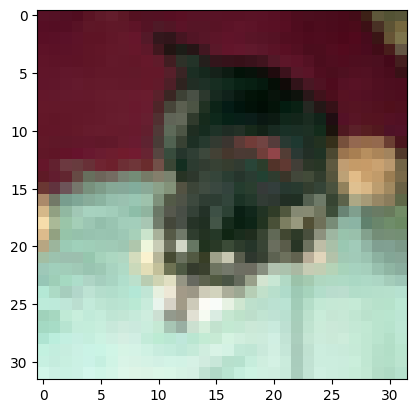

Known class: 5, target type: <class 'int'>
Predicted class: 6, predicted type: <class 'numpy.int64'>


In [13]:
indx = 128
imshow(ds["infer"][indx]["data"]["image"])
print(f"Known class: {test_data[b'labels'][indx]}, target type: {type(test_data[b'labels'][indx])}")
print(f"Predicted class: {predicted_classes[indx]}, predicted type: {type(predicted_classes[indx])}")

In [14]:
from sklearn.metrics import confusion_matrix

y_true = test_data[b"labels"]
y_pred = predicted_classes.tolist()
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

correct = 0
for t, p in zip(y_true, y_pred):
    correct += t == p

print("\nAccuracy:", correct / len(y_true))

Confusion Matrix:
 [[676  22  13   9  61  29  19  29 107  35]
 [115 591   3   5  23  14  24  26  92 107]
 [123  12  91  30 329 198  71 105  29  12]
 [ 40  11  10  94 154 452  91  96  28  24]
 [ 55   2  10  14 600 100  56 135  20   8]
 [ 18   3  18  20 116 609  34 157  19   6]
 [ 13  11  14  30 234 108 549  25   7   9]
 [ 30   5   0  12  78 121  18 712   7  17]
 [241  45   4   9  25  20   6  21 598  31]
 [ 81 155   2   9  24  32  39  66  90 502]]

Accuracy: 0.5022


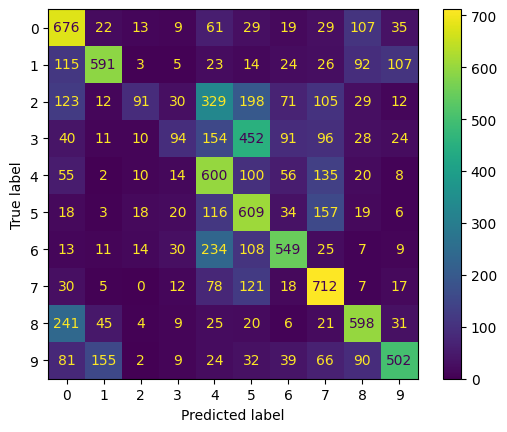

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming 'cm' is the result from the previous step
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {h.config['general']['results_dir']}